In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../..")

Submit: https://www.kaggle.com/c/dog-breed-identification/submissions?sortBy=date&group=all&page=1

In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/shmuma/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
PATH = "../../courses/dl1/data/dogs-breed/"

In [5]:
os.listdir(PATH)

['models', 'tmp', 'sample_submission.csv', 'test', 'labels.csv', 'train']

In [6]:
train_files = os.listdir(f'{PATH}/train')
train_files[:5]

['1b85a40f3c79e9d94e975216792ef52d.jpg',
 'b9757ae6aae924b0b5771d9dcd7590ca.jpg',
 'ee3ffc332086a4e74209a97b7b1330da.jpg',
 '9e31cc4d5a9f9e240ee8dcd15b2b537d.jpg',
 '1bbff1372370ec584225f44f6e33fb80.jpg']

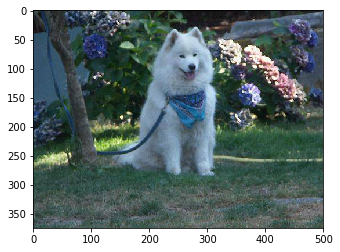

In [7]:
img = plt.imread(f'{PATH}/train/{train_files[1]}')
plt.imshow(img);

In [8]:
img.shape

(375, 500, 3)

In [5]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

Weights got from http://files.fast.ai/models/weights.tgz

In [6]:
arch = resnext101_64 #resnet34
sz = 224


In [7]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, "train", f"{PATH}/labels.csv", bs=bs, \
                                        test_name="test", tfms=tfms, suffix='.jpg', val_idxs=val_idxs)
    if sz > 900:
        return data
    else:
        return data.resize(sz, 'tmp')

In [8]:
def get_data_bnd300(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, "train", f"{PATH}/labels.csv", bs=bs, \
                                        test_name="test", tfms=tfms, suffix='.jpg', val_idxs=val_idxs)
    if sz > 300:
        return data
    else:
        return data.resize(sz, 'tmp')

In [12]:
data = get_data(sz, 64)

In [13]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [14]:
lrf = learn.lr_find()

 95%|█████████▍| 121/128 [01:19<00:04,  1.51it/s, loss=7.57]

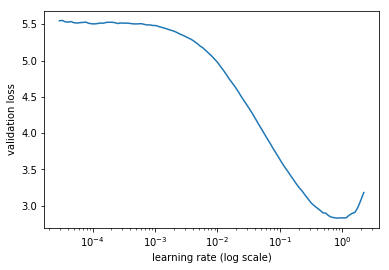

In [15]:
learn.sched.plot()

In [16]:
learn.fit(1e-1, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.754334   0.333724   0.888454  
    1      0.513215   0.306179   0.894325                    


KeyboardInterrupt: 

In [ ]:
learn.sched.plot_loss()

In [9]:
def produce_output(learn, out_fname):
    log_probs = learn.predict(True)
    probs = np.exp(log_probs)
    res_pd = pd.DataFrame(probs)
    res_pd.columns = learn.data.classes
    res_pd['id'] = list(map(lambda n: os.path.basename(n)[:-4], learn.data.test_ds.fnames))
    res_pd = res_pd.set_index('id')
    res_pd.to_csv(out_fname, compression='gzip')
    return FileLink(out_fname)

In [ ]:
produce_output(learn, "res1-r2.csv.gz")

# Augmentation

In [11]:
learn.precompute = False

In [56]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.139975   0.256232   0.921722  
    1      0.134757   0.255387   0.922211                    
    2      0.130046   0.255253   0.922211                    
    3      0.122017   0.250952   0.922211                    
    4      0.112521   0.251989   0.923679                    



[array([0.25199]), 0.9236790607820051]

In [59]:
produce_output(learn, "res2.csv.gz")

/home/shmuma/work/classes/classes-repo.git/fast.ai/fastai/my/dogsbreeds/res2.csv.gz

In [9]:
data = get_data(299, 32)
learn = ConvLearner.pretrained(arch, data, precompute=False)
#learn.unfreeze()

In [ ]:
lr = 1e-2
learn.fit([lr/4, lr/2, lr], 5, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.356152   0.266542   0.926614  
    1      0.3214     0.244231   0.931996                    
    2      0.273407   0.239652   0.933464                    
    3      0.271367   0.240746   0.929061                    
    4      0.244581   0.232532   0.928571                    
    5      0.208282   0.222771   0.934442                    
 98%|█████████▊| 126/128 [02:38<00:02,  1.26s/it, loss=0.205]    6      0.206521   0.223459   0.932975  
    7      0.214857   0.223812   0.932975                    
    8      0.195478   0.232469   0.927104                    
    9      0.16992    0.221554   0.92955                     
    10     0.157535   0.220959   0.926614                    


In [16]:
produce_output(learn, "res3.csv.gz")

/home/shmuma/work/classes/classes-repo.git/fast.ai/fastai/my/dogsbreeds/res3.csv.gz

Got 0.21306

# Train on small data set first, then increase

In [13]:
learn2 = ConvLearner.pretrained(arch, get_data(224, 32), precompute=False)
learn2.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.896267   0.48368    0.887965  
    1      0.609515   0.341179   0.902642                    
    2      0.471888   0.306567   0.90998                     


[array([0.30657]), 0.9099804304117326]

In [14]:
learn2.set_data(get_data(299, 32))
learn2.freeze()
learn2.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.390082   0.259077   0.921233  
    1      0.329144   0.248061   0.925147                    
    2      0.300309   0.241225   0.919765                    


[array([0.24122]), 0.9197651659905793]

In [15]:
learn2.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.261303   0.232319   0.921722  
    1      0.248321   0.231263   0.925147                    
    2      0.213545   0.227934   0.924658                    
    3      0.218127   0.234378   0.923679                    
    4      0.190345   0.232638   0.918297                    
    5      0.165197   0.224164   0.924168                    
    6      0.158763   0.225208   0.92955                     


[array([0.22521]), 0.9295499023859282]

In [20]:
produce_output(learn2, "res4.csv.gz")

/home/shmuma/work/classes/classes-repo.git/fast.ai/fastai/my/dogsbreeds/res4.csv.gz

Got 0.21432

In [17]:
learn2.freeze_to(-1)
learn2.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.116366   0.233011   0.92319   
    1      0.118375   0.235515   0.925636                    
    2      0.121943   0.231597   0.924168                    


[array([0.2316]), 0.924168297689255]

In [ ]:
produce_output(learn2.predict(True), "res4.csv.gz")

In [20]:
learn2.freeze_to??